In [6]:
# encoding: utf-8
# Author: Zhuangwei Kang

import os, sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
sys.path.append('../../')
from datapsr import *
import numpy as np
style.use(['classic'])
plt.rc('axes', axisbelow=True)
dpi=600

/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


[ -6.25        -6.25        -6.25       -14.73684211 -31.52173913]
[ -6.25        -6.25        -6.25       -14.73684211 -31.1827957 ]


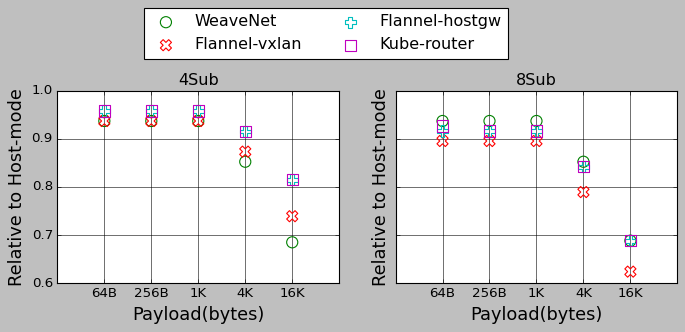

In [7]:
plugins = ['hostnetwork-udp', 'weavenet-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp']
data_len = [64, 256, 1024, 4096, 16384]
multicast_test = np.arange(12, 17)
num_subs = [4, 8]
markers = ['-', 'o', 'X', 'P', 's']


x = np.arange(len(data_len))
xticks=['64B', '256B', '1K', '4K', '16K']
labels = ['Host-mode', 'WeaveNet', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router']

fig, axes2d = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True, figsize=(10, 3))
ax1 = axes2d[0]
ax2 = axes2d[1]
plots=[]
throughput_perf, _ = load_data(multicast_test,  plugins, path='./4subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['packets/s(ave)']
    if cni == 'hostnetwork-udp':
        host_4sub = np.array(thr.tolist())
        base_4sub = np.array(thr.tolist())
        continue
    ax1.scatter(x, thr/base_4sub, marker=markers[i], label=labels[i], c='',edgecolors='C%d'%i, s=100)
    if cni == 'weavenet-udp':
        weave_4sub = np.array(thr.tolist())

throughput_perf, _ = load_data(multicast_test,  plugins, path='./8subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['packets/s(ave)']
    if cni == 'hostnetwork-udp':
        host_8sub = np.array(thr.tolist())
        base_8sub = np.array(thr.tolist())
        continue
    ax2.scatter(x, thr/base_8sub, marker=markers[i], c='',edgecolors='C%d'%i, s=100)
    if cni == 'weavenet-udp':
        weave_8sub = np.array(thr.tolist())
            
print(100*(weave_4sub-host_4sub)/host_4sub)
print(100*(weave_8sub-host_8sub)/host_8sub)

# plt.ylim(50,100)


ax1.set_xlabel('Payload(bytes)', fontsize=16)
ax1.set_ylabel('Relative to Host-mode', fontsize=16)
ax1.grid(linestyle='-')
ax1.set_title('4Sub')

ax2.set_xlabel('Payload(bytes)', fontsize=16)
ax2.set_ylabel('Relative to Host-mode', fontsize=16)
ax2.grid(linestyle='-')
ax2.set_title('8Sub')

ax1.legend(loc="center left", borderaxespad=0.1, scatterpoints = 1, bbox_to_anchor=(0.3,1.3), ncol=2)
plt.xticks(x, xticks)
plt.yticks(np.arange(6,11, 1)/10, np.arange(6,11, 1)/10)
plt.savefig('throughput.png', dpi=dpi, bbox_inches='tight')


Description: in this throughput test, we run a single publisher that continuously propagates messages to 4/8 subscribers in a frequency of 10 milliseconds with the DDS Multicast QoS policy being activated. Since Flannel and Kube-router lack support of multicast, we run unicast test for them and enable multicast for hostnetwork and weavenet.

Purpose: Multicast is a crucial feature needed by Publish/Subscribe middleware, such as DDS, that is usually deployed in systems requiring one-to-many message distribution. To this end, it is necessary to understand multicast performance overhead in the Hybrid-Arch K8s deployment. Moreover, we know Kuberouter and Flannel-Hostgw perform much better than Weavenet, according to the previous CNI throughput tests. A question that needs to be answered is whether Weavenet multicast can make up for the overhead caused by VXLAN encapsulation, after then becoming a more promising solution in multi-subscriber use cases.

Analysis: The overall trend suggests that the number of delivered samples per second remains stable before 1KB and then drops down as the payload size increase. However, the degradation for virtual network plugins is more significant than that of hostnetwork. The reason is virtual network plugins need to perform more onerous packet fragmentation and encapsulation when message size is larger than MTU. When the number of subscribers grows from 4 to 8, the performance of hostnetwork and weavenet remains the same, while the degradation happens in Flannel and Kuberouter due to the nature of unicast. We can also see the curves for Kuberouter and Flannel-Hostgw overlap, meaning they have nearly the same performance. Weavenet multicast suffers 6.3%~31.5% performance overhead relative to hostnetwork. Kuberouter and Flannel-Hostgw consistently beat Weavenet multicast when running 4 subscribers, while Weavenet is more preponderant in the 8-subscriber scenario except when the payload is 16KB. Basically, the gap between Weavenet multicast and L3 virtual network solutions keeps shrinking as the increasing of message size when there are 8 subscribers. Accordingly, although Weavenet is the only CNI supporting multicast, it may not deliver the best performance comparing to Kuberouter and Flannel-Hostgw, especially in resource-constrained edge environments. The exact CNI selection decision in this case highly couples to the cluster scale and traffic load.

/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


[30.51470588 27.17584369 28.67383513 16.44067797 -9.3373494 ]
[30.93721565 28.82882883 30.03597122 18.1122449  -2.97107115]


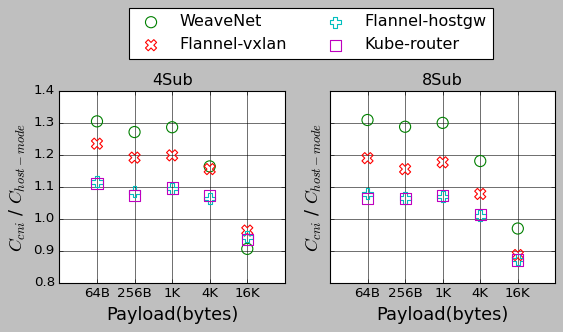

In [8]:
plugins = ['hostnetwork-udp', 'weavenet-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp']
data_len = [64, 256, 1024, 4096, 16384]
multicast_test = np.arange(12, 17)
num_subs = [4, 8]
markers = ['-', 'o', 'X', 'P', 's']


x = np.arange(len(data_len))
xticks=['64B', '256B', '1K', '4K', '16K']
labels = ['Host-mode', 'WeaveNet', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router']

fig, axes2d = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True, figsize=(8, 3))
ax1 = axes2d[0]
ax2 = axes2d[1]
plots=[]
throughput_perf, _ = load_data(multicast_test,  plugins, path='./4subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['cpu']
    if cni == 'hostnetwork-udp':
        host_4sub = np.array(thr.tolist())
        base_4sub = np.array(thr.tolist())
        continue
    ax1.scatter(x, thr/base_4sub, marker=markers[i], label=labels[i], c='',edgecolors='C%d'%i, s=100)
    if cni == 'weavenet-udp':
        weave_4sub = np.array(thr.tolist())

throughput_perf, _ = load_data(multicast_test,  plugins, path='./8subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['cpu']
    if cni == 'hostnetwork-udp':
        host_8sub = np.array(thr.tolist())
        base_8sub = np.array(thr.tolist())
        continue
    ax2.scatter(x, thr/base_8sub, marker=markers[i], c='',edgecolors='C%d'%i, s=100)
    if cni == 'weavenet-udp':
        weave_8sub = np.array(thr.tolist())
            
print(100*(weave_4sub-host_4sub)/host_4sub)
print(100*(weave_8sub-host_8sub)/host_8sub)

ax1.set_xlabel('Payload(bytes)', fontsize=16)
ax1.set_ylabel('$C_{cni}$ / $C_{host-mode}$', fontsize=16)
ax1.grid(linestyle='-')
ax1.set_title('4Sub')

ax2.set_xlabel('Payload(bytes)', fontsize=16)
ax2.set_ylabel('$C_{cni}$ / $C_{host-mode}$', fontsize=16)
ax2.grid(linestyle='-')
ax2.set_title('8Sub')

ax1.legend(loc="center left", borderaxespad=0.1, scatterpoints = 1, bbox_to_anchor=(0.3,1.3), ncol=2)
plt.xticks(x, xticks)
# plt.yticks(np.arange(6,11, 1)/10, np.arange(6,11, 1)/10)
plt.savefig('cpu.png', dpi=dpi, bbox_inches='tight')


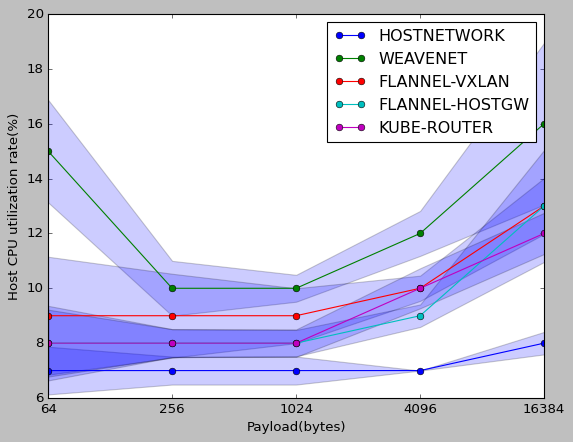

In [9]:

plt.xticks(range(len(data_len)), data_len)
for cni in plugins:
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in range(len(data_len)):
        data = pd.read_csv('4subs/throughputTest/%s/test-%d/metrics.csv' % (cni, 12+i))
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(90%)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(90%)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    plt.plot(np.arange(len(data_len)), pub_cpu, label='-'.join(cni.split('-')[:-1]).upper(), marker='o')
    plt.fill_between(np.arange(len(data_len)), np.reshape(np.array(pub_cpu)-np.array(pub_cpu_std), len(data_len)), np.reshape(np.array(pub_cpu)+np.array(pub_cpu_std), len(data_len)), alpha=.2)

# plt.ylim(0, 100)
plt.legend()
plt.xlabel('Payload(bytes)')
plt.ylabel('Host CPU utilization rate(%)')
# plt.grid(axis='y', linestyle=':')
plt.show()

/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


[ 72.31759657  68.16326531  74.63706234 210.42345277 476.10652663]
[ 72.31759657  68.16326531  74.63706234 210.42345277 476.10652663]


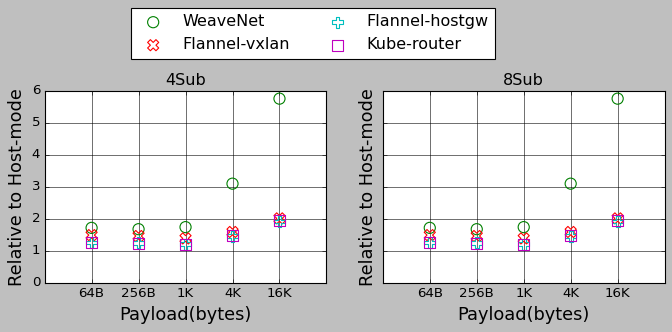

In [10]:
plugins = ['hostnetwork-udp', 'weavenet-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp']
data_len = [64, 256, 1024, 4096, 16384]
multicast_test = np.arange(12, 17)
num_subs = [4, 8]
markers = ['-', 'o', 'X', 'P', 's']


x = np.arange(len(data_len))
xticks=['64B', '256B', '1K', '4K', '16K']
labels = ['Host-mode', 'WeaveNet', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router']
fig, axes2d = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True, figsize=(10, 3))
ax1 = axes2d[0]
ax2 = axes2d[1]
plots=[]
_, latency_perf = load_data(multicast_test,  plugins, path='./4subs', latencyTest=True)
for i, cni in enumerate(plugins):
    lat = latency_perf[latency_perf['cni'] == cni]['90%']
    if cni == 'hostnetwork-udp':
        host_4sub = np.array(lat.tolist())
        base_4sub = np.array(lat.tolist())
        continue
    ax1.scatter(x, lat/base_4sub, marker=markers[i], label=labels[i], c='',edgecolors='C%d'%i, s=100)
    if cni == 'weavenet-udp':
        weave_4sub = np.array(lat.tolist())

throughput_perf, _ = load_data(multicast_test,  plugins, path='./8subs')
for i, cni in enumerate(plugins):
    lat = latency_perf[latency_perf['cni'] == cni]['90%']
    if cni == 'hostnetwork-udp':
        host_8sub = np.array(lat.tolist())
        base_8sub = np.array(lat.tolist())
        continue
    ax2.scatter(x, lat/base_8sub, marker=markers[i], c='',edgecolors='C%d'%i, s=100)
    if cni == 'weavenet-udp':
        weave_8sub = np.array(lat.tolist())
            
print(100*(weave_4sub-host_4sub)/host_4sub)
print(100*(weave_8sub-host_8sub)/host_8sub)

# plt.ylim(50,100)
ax1.legend(loc="center left", borderaxespad=0.1, scatterpoints = 1, bbox_to_anchor=(0.3,1.3), ncol=2)
plt.xticks(x, xticks)
# plt.yticks(np.arange(6,11, 1)/10, np.arange(6,11, 1)/10)

ax1.set_xlabel('Payload(bytes)', fontsize=16)
ax1.set_ylabel('Relative to Host-mode', fontsize=16)
ax1.grid(linestyle='-')
ax1.set_title('4Sub')

ax2.set_xlabel('Payload(bytes)', fontsize=16)
ax2.set_ylabel('Relative to Host-mode', fontsize=16)
ax2.grid(linestyle='-')
ax2.set_title('8Sub')

plt.savefig('latency.png', dpi=dpi, bbox_inches='tight')